## <center>Exercises 4: Molecular dynamic simulation with Verlet algorithm</center>

In this notebook we will learn how to simulate the molecular dynamics of a system in the gas, liquid and solid phase, and compute macroscopical quantities such as energy, temperature and pressure. 
<br> We are going to simulate the behavior of an Argon sample in solid, liquid and gas phase under the action of a Lennard-Jones potential, that is 
$$V_{LJ} = 4 \epsilon \left[\left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6\right]$$
in reduced units ($\sigma=\epsilon=1$).
<br /> We are using a Verlet algorithm for molecular dynamics, a time-reversible algorithm which satisfies energy conservation: to compute the new position at each step we need the two previous ones and the forces the molecules are subjected to, which we can obtain from the potential energy. 
<br /> The approximations used are the following:
- considering space as an infinite lattice composed by identical boxes, a symmetry which almost doesn't affect molecules of a system with a short range potential as Lennard-Jones; when a molecule passes from a box to the next one its image enters the first bow from the opposite side, so the system has no walls (periodic boundary conditions)
- a molecule only interacts with molecules (or images) inside a region equal in size to the box and centered in the molecule itself (minimum image convention)
- applying a spherical cut-off to the potential, which means ignoring all interactions beyond the cut-off distance $r_c$; for sufficiently large $r_c$ and short range potentials this does not imply consistent perturbations

Here we have added the computation of pressure (Exercise 1, only c++ code), that in reduced units is
$$ P = \rho T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48 \left[ \left(\frac{1}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{1}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$
where we have assumed $\sigma=\epsilon=k_{B}=1$.
<br> All the quantities have been evaluated in reduced units; potential, kinetic and total energy are computed per particle.

### Exercise 2

<br /> For all three phases the system is prepared in the same crystalline configuration and needs some steps to reach equilibrium before simulating its behaviour and measuring properties. In fact, the crystalline structure is the configuration with the minimum of potential energy; this configuration is too ordered for a real solid, and it doesn't represent the liquid or gas phase that need some initial steps for the system to melt and reach these two phases.
<br> The thermodynamical conditions of the system in the three pahses are:
- solid phase:  𝜌⋆=1.1 ,  𝑇⋆=0.8  (cut-off radius:  𝑟𝑐=2.2 )
- liquid phase:  𝜌⋆=0.8 ,  𝑇⋆=1.1  (cut-off radius:  𝑟𝑐=2.5 )
- gas phase:  𝜌⋆=0.05 ,  𝑇⋆=1.2  (cut-off radius:  𝑟𝑐=5.0 )

These quantities are assumed to be fixed; nevertheless, as we will see and explain below, during the first steps of the simulation (that will be the equilibrations steps) temperature changes significantly. Therefore we will start the simulations with a different temperature from the one given, so that after the equilibration steps it converges to the requested value.
<br> During the equilibration phase we are going to plot the average of temperature in each block in order to monitor its fluctuations; when this value seems to stabilize around the given one we have reached the equilibrium and can start the simulation. To make sure that we haven't got stuck in an apparent equilibrium condition we can plot the average of another property (for example potential energy) and compare the two graphs.

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Solid Phase

#### - Equilibration:

The system is prepared in a crystalline structure, but a solid will never be in such a perfect configuration: a real solid phase turns out to be more disordered compared to the ideal one, so the potential energy (starting from the lowest value, the one of the crystalline structure) grows as the solid gets more disordered, causing kinetic energy to decrease in order to keep the total energy constant; that's why temperature is observed to drop in the initial steps.\
We can start the simulation from a higher temperature, here $T=1.5$, that drops until the desired value $T=0.8$ after approximately $1000$ steps: this is a phase of equilibration which won't measure properties in our code; after these first $1000$ steps the simulation measurements can start.

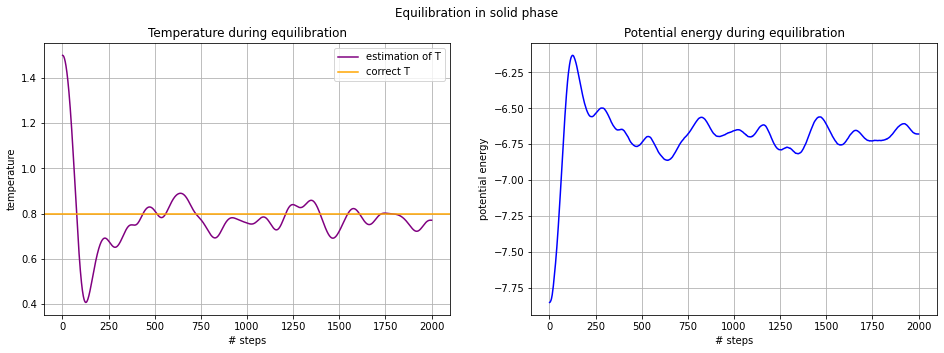

In [22]:
# reading data
nstep_s, temp_s = np.loadtxt("./ex_2/Output/Solid/Equilibration/output_temp.dat", usecols=(0,1), delimiter=None, unpack='true')
epot_s = np.loadtxt("./ex_2/Output/Solid/Equilibration/output_epot.dat", usecols=(1), delimiter=None, unpack='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Equilibration in solid phase')

ax1.plot(nstep_s,temp_s,color='purple',label='estimation of T')
ax1.axhline(y=0.8,color='orange',label='correct T')
ax1.set_xlabel('# steps')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature during equilibration')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(nstep_s,epot_s,color='blue')
ax2.set_xlabel('# steps')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy during equilibration')
ax2.grid(True)

plt.show()

#### - Simulation:

Now that the system has been through this phase of equilibration and has reached the given temperature, we can start the simulation. We are interested in computing potential energy, kinetic energy, temperature and pressure; we are using data blocking for our simulations, with $50$ blocks of $2000$ steps each.

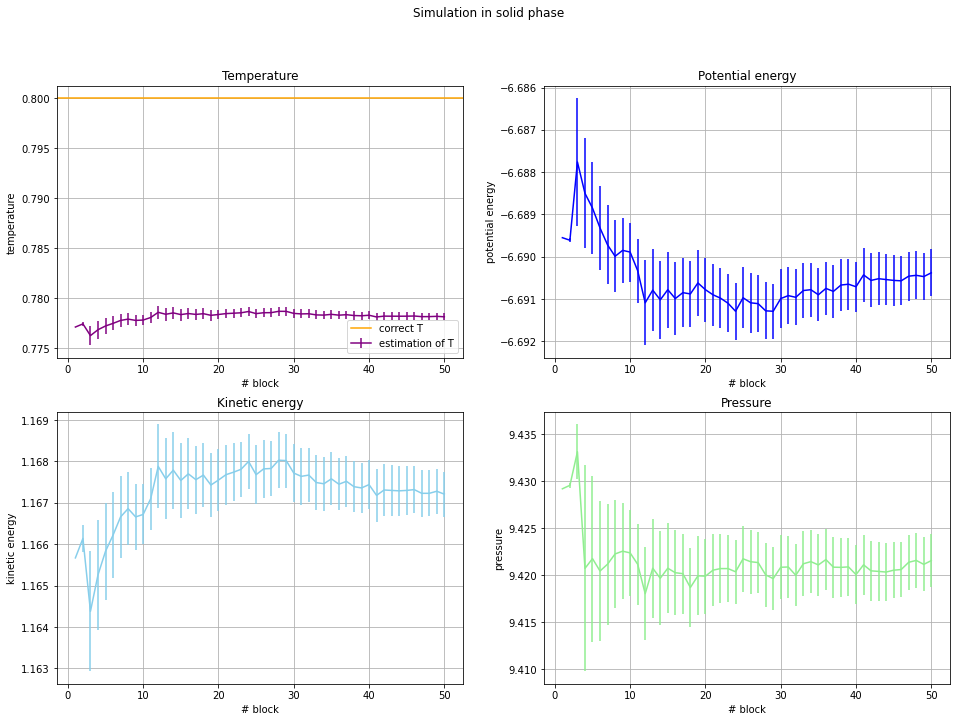

In [24]:
# reading data
nblk_s, temp_s, err_temp_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_temp.dat", usecols=(0,2,3), delimiter=None, unpack='true')
epot_s, err_epot_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
ekin_s, err_ekin_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_ekin.dat", usecols=(2,3), delimiter=None, unpack='true')
press_s, err_press_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
etot_s, err_etot_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_etot.dat", usecols=(2,3), delimiter=None, unpack='true')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,11))
fig.suptitle('Simulation in solid phase')

ax1.errorbar(nblk_s,temp_s,yerr=err_temp_s,color='purple',label='estimation of T')
ax1.axhline(y=0.8,color='orange',label='correct T')
ax1.set_xlabel('# block')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature')
ax1.legend(loc='best')
ax1.grid(True)

ax2.errorbar(nblk_s,epot_s,yerr=err_epot_s,color='blue')
ax2.set_xlabel('# block')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy')
ax2.grid(True)

ax3.errorbar(nblk_s,ekin_s,yerr=err_ekin_s,color='skyblue')
ax3.set_xlabel('# block')
ax3.set_ylabel('kinetic energy')
ax3.set_title('Kinetic energy')
ax3.grid(True)

ax4.errorbar(nblk_s,press_s,yerr=err_press_s,color='lightgreen')
ax4.set_xlabel('# block')
ax4.set_ylabel('pressure')
ax4.set_title('Pressure')
ax4.grid(True)

plt.show()

We can also plot potential, kinetic and total energy in the same graph in order to see how the algorithm conserves total energy. In the last graph we have added some numbers to kinetic and potential energy in order to see their oscillations in the same plot; the values represented are not correct, but their aim is just showing how the two quantities compensate each other during the simulation in order to maintain total energy constant.

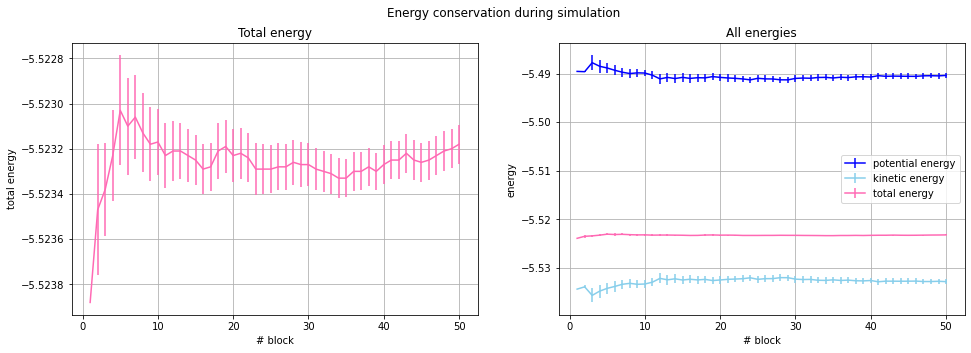

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Energy conservation during simulation')

ax1.errorbar(nblk_s,etot_s,yerr=err_etot_s,color='hotpink',label='total energy')
ax1.set_xlabel('# block')
ax1.set_ylabel('total energy')
ax1.set_title('Total energy')
ax1.grid(True)

ax2.errorbar(nblk_s,epot_s+1.2,yerr=err_epot_s,color='blue',label='potential energy')
ax2.errorbar(nblk_s,ekin_s-6.7,yerr=err_ekin_s,color='skyblue',label='kinetic energy')
ax2.errorbar(nblk_s,etot_s,yerr=err_etot_s,color='hotpink',label='total energy')
ax2.set_xlabel('# block')
ax2.set_ylabel('energy')
ax2.set_title('All energies')
ax2.legend(loc='best')
ax2.grid(True)

plt.show()

#### 2. Liquid Phase

#### - Equilibration:

The equilibration phase is needed because, as we can see in the graph below, temperature drops drastically from the given value for an initial amount of time steps. Again, the reason is that the simulation starts from a crystalline structure, which is far from the disordered phase of a liquid: the potential energy of the initial configuration is very low, so it grows as the liquid melts, therefore, to conserve the total energy, the kinetic energy decreases and so does temperature.\
We can start the simulation from a higher temperature, here $T=2$, that drops until the desired value $T=1.1$ after approximately $5000$ steps: this is a phase of equilibration which won't measure properties in our code; after these first $5000$ steps the simulation measurements can start.

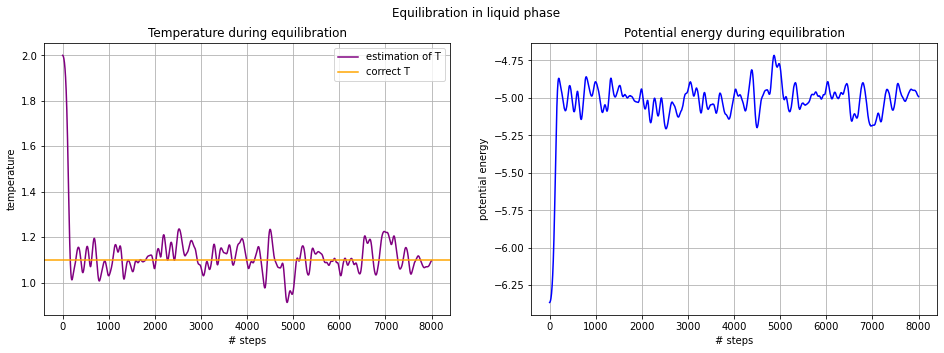

In [25]:
# reading data
nstep_l, temp_l = np.loadtxt("./ex_2/Output/Liquid/Equilibration/output_temp.dat", usecols=(0,1), delimiter=None, unpack='true')
epot_l = np.loadtxt("./ex_2/Output/Liquid/Equilibration/output_epot.dat", usecols=(1), delimiter=None, unpack='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Equilibration in liquid phase')

ax1.plot(nstep_l,temp_l,color='purple',label='estimation of T')
ax1.axhline(y=1.1,color='orange',label='correct T')
ax1.set_xlabel('# steps')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature during equilibration')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(nstep_l,epot_l,color='blue')
ax2.set_xlabel('# steps')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy during equilibration')
ax2.grid(True)

plt.show()

#### - Simulation:

The simulation for the liquid phase has been done with the same statistical parameters as the case of the solid phase. Below we are showing the results of the simulation and then focusing on energy conservation; we remind that the values of kinetic and potential energy in the last plot are translated so as to show the trend of the two quantities at the same time.

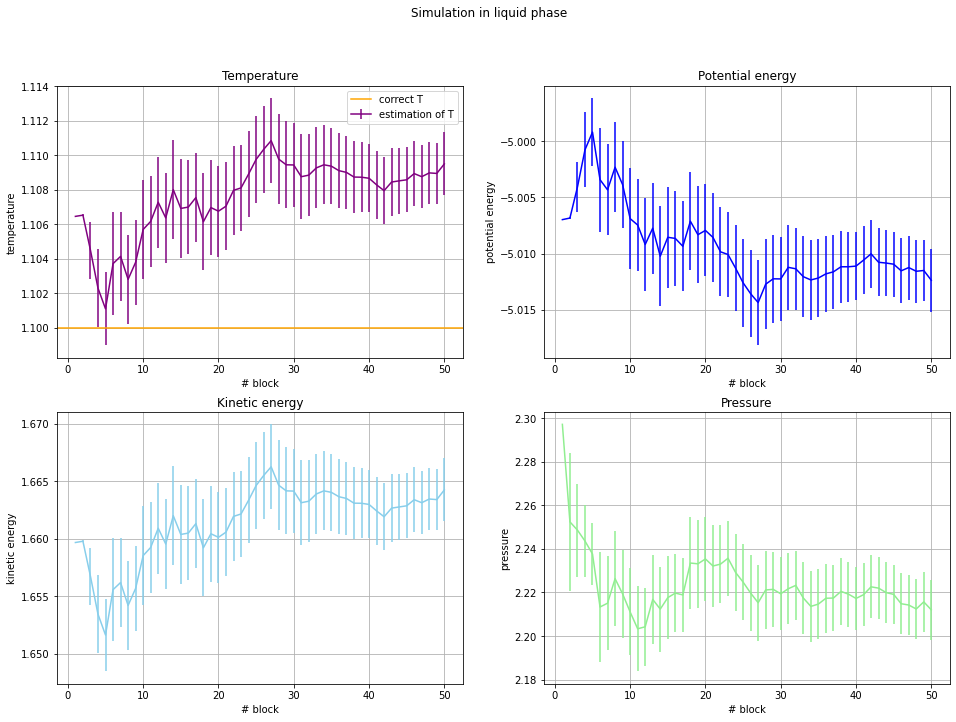

In [26]:
# reading data
nblk_l, temp_l, err_temp_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_temp.dat", usecols=(0,2,3), delimiter=None, unpack='true')
epot_l, err_epot_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
ekin_l, err_ekin_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_ekin.dat", usecols=(2,3), delimiter=None, unpack='true')
press_l, err_press_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
etot_l, err_etot_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_etot.dat", usecols=(2,3), delimiter=None, unpack='true')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,11))
fig.suptitle('Simulation in liquid phase')

ax1.errorbar(nblk_l,temp_l,yerr=err_temp_l,color='purple',label='estimation of T')
ax1.axhline(y=1.1,color='orange',label='correct T')
ax1.set_xlabel('# block')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature')
ax1.legend(loc='best')
ax1.grid(True)

ax2.errorbar(nblk_l,epot_l,yerr=err_epot_l,color='blue')
ax2.set_xlabel('# block')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy')
ax2.grid(True)

ax3.errorbar(nblk_l,ekin_l,yerr=err_ekin_l,color='skyblue')
ax3.set_xlabel('# block')
ax3.set_ylabel('kinetic energy')
ax3.set_title('Kinetic energy')
ax3.grid(True)

ax4.errorbar(nblk_l,press_l,yerr=err_press_l,color='lightgreen')
ax4.set_xlabel('# block')
ax4.set_ylabel('pressure')
ax4.set_title('Pressure')
ax4.grid(True)

plt.show()

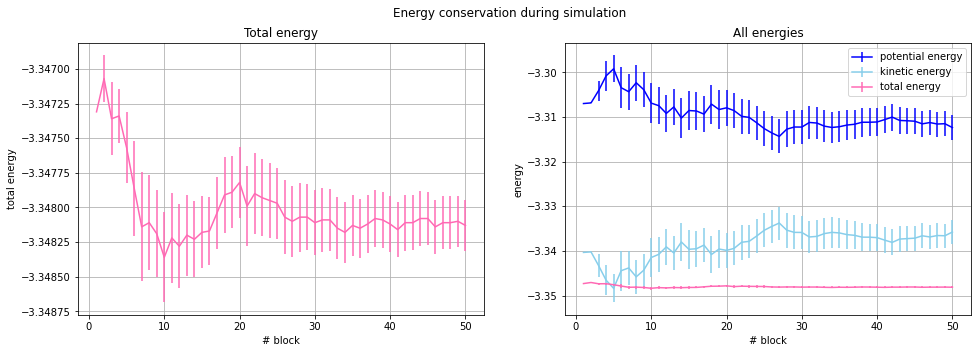

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Energy conservation during simulation')

ax1.errorbar(nblk_l,etot_l,yerr=err_etot_l,color='hotpink',label='total energy')
ax1.set_xlabel('# block')
ax1.set_ylabel('total energy')
ax1.set_title('Total energy')
ax1.grid(True)

ax2.errorbar(nblk_l,epot_l+1.7,yerr=err_epot_l,color='blue',label='potential energy')
ax2.errorbar(nblk_l,ekin_l-5,yerr=err_ekin_l,color='skyblue',label='kinetic energy')
ax2.errorbar(nblk_l,etot_l,yerr=err_etot_l,color='hotpink',label='total energy')
ax2.set_xlabel('# block')
ax2.set_ylabel('energy')
ax2.set_title('All energies')
ax2.legend(loc='best')
ax2.grid(True)

plt.show()

#### 3. Gas Phase

#### - Equilibration: 

Here for the initial time steps temperature increases, showing an opposite behaviour compared to liquid and solid phase. Given that the simulation starts from a crystalline structure again, one may think that the system should behave in the same way as for the liquid phase. Nevertheless the gas phase has a much lower density: particles start moving from the crystalline configuration, but due to the very low density the system feels as if the box sides had been expanded; therefore the particles try to move towards each other falling into potential wells, making the potential energy decrease; kinetic energy increases to maintain the total energy constant, and so does temperature.
<br> We can start the simulation from a lower temperature, here $T=1$, that increases until the desired value $T=1.2$ after approximately $4000$ steps: anyway we will count $10000$ steps for equilibration, because both temperature and potential energy seem to stabilize more around this value.

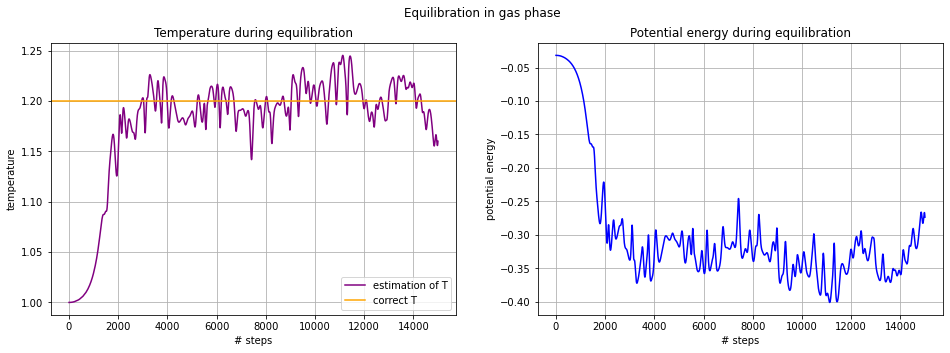

In [27]:
# reading data
nstep_g, temp_g = np.loadtxt("./ex_2/Output/Gas/Equilibration/output_temp.dat", usecols=(0,1), delimiter=None, unpack='true')
epot_g = np.loadtxt("./ex_2/Output/Gas/Equilibration/output_epot.dat", usecols=(1), delimiter=None, unpack='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Equilibration in gas phase')

ax1.plot(nstep_g,temp_g,color='purple',label='estimation of T')
ax1.axhline(y=1.2,color='orange',label='correct T')
ax1.set_xlabel('# steps')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature during equilibration')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(nstep_g,epot_g,color='blue')
ax2.set_xlabel('# steps')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy during equilibration')
ax2.grid(True)

plt.show()

#### - Simulation:

Again the simulation has the same number of blocks and steps per block as the other two cases. The results are shown as follows, with a particular attention on energy conservation (again the values of energies in the last plot are adjusted so that we can see how potential and kinetic energy behave at the same time).

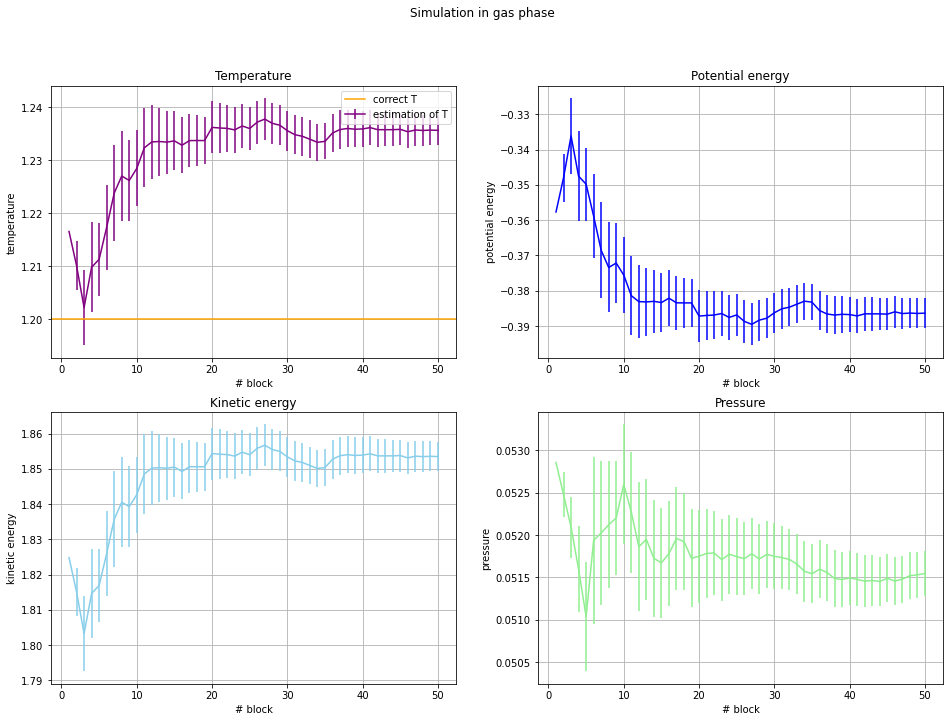

In [28]:
# reading data
nblk_g, temp_g, err_temp_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_temp.dat", usecols=(0,2,3), delimiter=None, unpack='true')
epot_g, err_epot_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
ekin_g, err_ekin_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_ekin.dat", usecols=(2,3), delimiter=None, unpack='true')
press_g, err_press_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
etot_g, err_etot_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_etot.dat", usecols=(2,3), delimiter=None, unpack='true')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,11))
fig.suptitle('Simulation in gas phase')

ax1.errorbar(nblk_g,temp_g,yerr=err_temp_g,color='purple',label='estimation of T')
ax1.axhline(y=1.2,color='orange',label='correct T')
ax1.set_xlabel('# block')
ax1.set_ylabel('temperature')
ax1.set_title('Temperature')
ax1.legend(loc='best')
ax1.grid(True)

ax2.errorbar(nblk_g,epot_g,yerr=err_epot_g,color='blue')
ax2.set_xlabel('# block')
ax2.set_ylabel('potential energy')
ax2.set_title('Potential energy')
ax2.grid(True)

ax3.errorbar(nblk_g,ekin_g,yerr=err_ekin_g,color='skyblue')
ax3.set_xlabel('# block')
ax3.set_ylabel('kinetic energy')
ax3.set_title('Kinetic energy')
ax3.grid(True)

ax4.errorbar(nblk_g,press_g,yerr=err_press_g,color='lightgreen')
ax4.set_xlabel('# block')
ax4.set_ylabel('pressure')
ax4.set_title('Pressure')
ax4.grid(True)

plt.show()

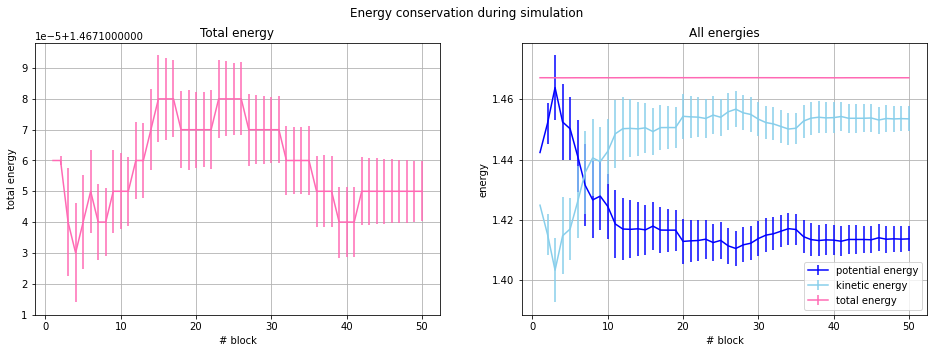

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Energy conservation during simulation')

ax1.errorbar(nblk_g,etot_g,yerr=err_etot_g,color='hotpink',label='total energy')
ax1.set_xlabel('# block')
ax1.set_ylabel('total energy')
ax1.set_title('Total energy')
ax1.grid(True)

ax2.errorbar(nblk_g,epot_g+1.8,yerr=err_epot_g,color='blue',label='potential energy')
ax2.errorbar(nblk_g,ekin_g-0.4,yerr=err_ekin_g,color='skyblue',label='kinetic energy')
ax2.errorbar(nblk_g,etot_g,yerr=err_etot_g,color='hotpink',label='total energy')
ax2.set_xlabel('# block')
ax2.set_ylabel('energy')
ax2.set_title('All energies')
ax2.legend(loc='best')
ax2.grid(True)

plt.show()

#### General conclusions

As shown in the figures above, after the initial phase of equilibration the measured quantities oscillate around an almost constant value within their errorbars.
<br> The initial temperature is not reached exactly, but we always end up very near; if we want a nearer value, we can try to change again the temperature we choose for the start of the equilibration phase.
<br> In the results we can see a good energy conservation, which tells us that the algorithm is working well: in fact, the point of the Verlet algorithm is conserving the energy, so this feature has to come out of the results of the simulations.